In [103]:
from pathlib import Path
from PIL import Image
import numpy as np
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

In [51]:
def get_base_segments_dict(dirpath):

    nodefiles = [child.name for child in sorted(dirpath.iterdir()) if (child.name[0]!='.') & (child.is_file()) & ("desktop" not in child.name)]

    # Create a base_segments dictionary of all cells in the directory
    base_segments = {}
    for x in nodefiles:
        # print(x)
        with open(dirpath / x, 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
            cell_data=myfile.read()
            cell_data = json.loads(cell_data)
        base_segments[x] = set([a for b in cell_data['base_segments'].values() for a in b]) #cell.cell_data['base_segments']
        # base_segments[x] = set([a for b in cell_data['base_segments'].values() for a in b]) #cell.cell_data['base_segments']

    return base_segments

## 2. Settings definitions

Whether you are converting from neuroglancer or creating a new reconstruction, the settings_dict parameters is needed to create CREST json files with correct formatting. 
- 'save_dir' : the directory where JSON files are saved 
- 'cred' and 'db_path' : specify the path to the agglomeration database file on your local computer. 

In [47]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

# Molecular layer fit

In [159]:
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

In [160]:
# Define mathematical function for curve fitting 
def func(xy, a, b, c, d, e, f, g, h):  # #h):#
    x, y = xy 
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x**3 + g*y**3 + h*x*y # + h*x*y #

In [161]:
Path(settings_dict['save_dir']).parent.parent

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome')

In [162]:
neuroglancer_path = Path(settings_dict['save_dir']).parent.parent / 'blender/soma_locations/layer-molecular_annotation.json'
voxel_sizes = [16,16,30]
nl_ = 'molecular'

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)
    
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']]

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

In [163]:
# Perform curve fitting 
popt, pcov = curve_fit(func, (x_pts, z_pts), y_pts) 
  
# Print optimized parameters 
print(popt) 

[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



# cell types for all files in directory

In [539]:
nodefiles = get_cell_filepaths(Path(settings_dict['save_dir'])) 

## from file

In [347]:
dirpath = Path(settings_dict['save_dir'])

df_type = pd.read_csv(dirpath / 'metadata/df_type.csv')

## manual type

In [540]:
cell_type = {}
not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[int(x)]=np.NaN
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        
df_type = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])

df_type.loc[df_type['cell_type'].isin(['dml']),'cell_type']='mli'
df_type.loc[df_type['cell_type'].isin(['grc-d']),'cell_type']='grc'
df_type.loc[df_type['cell_type'].isin(['grc-s']),'cell_type']='smpl'
df_type.loc[df_type['cell_type'].isin(['pfm']),'cell_type']='pf'

the following cells are not typed in the main network
[]


## auto type

this field is populated when an auto-typing of the cells was different from the manual typing

In [541]:
cell_type = {}
# not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('auto') 
    if (cell.get_ctype('auto') == []) | (cell.get_ctype('auto') == ''):
        cell_type[int(x)]=np.NaN
        # not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
# print('the following cells are not typed in the main network')
# print(not_typed)        
        
df_type_auto = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])


In [542]:
df_type_auto.dropna(inplace=True)

In [543]:
df_type_auto.head()

,id,cell_type
99,127607174,mg2
101,127672247,mg2
149,129572524,mg1
725,213501262,mg1
750,214440956,mg2


## combine manual and auto df_type

In [544]:
for i,r in df_type_auto.iterrows():
    df_type.loc[i,'cell_type'] = r['cell_type'] # the match up of i for df_type and _auto depends on both being made by iterating over the same nodefiles list

In [545]:
df_type.head()

,id,cell_type
0,102463116,pf
1,103366246,uk
2,103549879,mli
3,109461049,fov
4,109502641,mli


In [546]:
df_type.to_csv(dirpath / 'metadata/df_type.csv')

# load VAST segment location data from Matlab

In [40]:
# Path to the folder containing the PNG images
folder_path = Path("/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/VAST/rnascope_compare")

In [547]:
df_segments = pd.read_csv(folder_path / 'df_segments.csv')

In [548]:
df_segments.head()

,Unnamed: 0,x,y,z,segment
0,2,16539,18808,1796,392163654
1,3,17000,18467,1686,306306823
2,4,17341,18288,1677,305177235
3,5,17266,18197,1799,391049363
4,6,16709,18217,1845,391034236


In [549]:
directory_path = Path(settings_dict['save_dir']) # specify the directory path
crest = ecrest(settings_dict,segment_id = df_segments['segment'].values[0], launch_viewer=False)

Creating base segment graph for cell 392163654 Cell Reconstruction
all base locations for 813 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstruction of 392163654. No file saved yet -- save manually.


In [550]:
base_segments = get_base_segments_dict(Path(directory_path))

In [551]:
# for each row in df_segments
for i,r in df_segments.iterrows():
    
# find overlapping cell_id
    segid_to_find = r['segment']

    cell_id = [k.split('_')[2] for k,v in base_segments.items() if str(segid_to_find) in v]
    # print(cell_id)
    if cell_id == []:
        cell_id = np.NaN
        cell_type = 'none'
    elif cell_id != []:
        if len(cell_id)>1:
            print(f'{len(cell_id)} cells match: {cell_id}')
        if len(cell_id)==1:
            cell_id = cell_id[0]
            # print(cell_id)
            # print(df_type[df_type['id'].isin([cell_id])]['cell_type'])
            cell_type = df_type[df_type['id'].isin([int(cell_id)])]['cell_type'].values[0]
        
    # print(i,segid_to_find,cell_id)

# enter cell_id in new column (empty or NaN if none)
    df_segments.loc[i,'cell_id'] = cell_id
    df_segments.loc[i,'cell_type']=cell_type



In [552]:
df_segments.head()

,Unnamed: 0,x,y,z,segment,cell_id,cell_type
0,2,16539,18808,1796,392163654,306291045,h
1,3,17000,18467,1686,306306823,306306044,h
2,4,17341,18288,1677,305177235,305176846,smpl
3,5,17266,18197,1799,391049363,391049801,smpl
4,6,16709,18217,1845,391034236,391034186,sgx1


# Create new reconstruction for missing cells

In [471]:
mask = (df_segments['cell_type']=='none') & (df_segments['segment']==0)
df_segments[mask]#['segment'].values

,Unnamed: 0,x,y,z,segment,cell_id,cell_type
75,77,18210,18026,1678,0,NaN,none
115,117,19606,16634,1547,0,NaN,none
143,145,15416,15880,1635,0,NaN,none


In [472]:
segment_id = '300673220'#     283375247
crest = ecrest(settings_dict,segment_id = segment_id, launch_viewer=True)

crest.change_key_binding({"alt+mousedown0" : "add-or-remove-seg"})

crest.add_endpoint_annotation_layers(['soma'],link=True) # spine_inputs
print(crest.get_ctype('manual'))

### check for duplicates in working directories

Creating base segment graph for cell 300673220 Cell Reconstruction
all base locations for 411 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstruction of 300673220. No file saved yet -- save manually.
updating viewer status message: Current Base Segment Counts: unknown: 411, axon: 0, basal dendrite: 0, apical dendrite: 0, dendrite: 0, multiple: 0
[]
2 base segments removed from 2 connected components
1 base segments removed from 1 connected components
1 base segments removed from 1 connected components
3 base segments removed from 3 connected components
1 base segments removed from 1 connected components
1 base segments removed from 1 connected components
1 base segments removed from 1 connected comp

In [474]:
# print(f'this file is: {cell_filepaths[cell_id].name}')
print('')
# actually check for duplicates of current reconstruction with base segments dictionary
# to save time, this line can be run alone after initializing base_segments dictionary above
print('overlap in main network:'); df = crest.check_duplicates(base_segments); display(df)
# print('overlap in Rachel folder:'); df = crest.check_duplicates(base_segments_todo1); display(df)
# print('overlap in todo folder:'); df = crest.check_duplicates(base_segments_todo2); display(df)


overlap in main network:


,self,dups,overlap-percent,number_seg_lap


### define cell type and save

In [475]:
cell_type = 'sgx2' # Assign the cell type then run the code cell

crest.define_ctype(cell_type,"manual")

In [476]:
crest.save_cell_graph()

Saved cell 300673220 reconstruction locally at 2024-10-10 12.57.39



## EDIT reconstruction from file

If you wanted to edit a reconstruction from an existing file, you would use the following code block to launch.

Specify the cell_id and the path to the directory that cell is in. 

> NOTE: You can also directly copy paste the full filepath to the cell you want to open and pass it to the ```filepath``` flag.  
In that case, the only code you need is crest = ecrest(settings_dict,filepath= [*paste filepath here*], launch_viewer=True)

To change the save location you can specify the ```directory_path``` flag in the ```save_cell_graph()``` module

> To overwrite a file (not recommended), specify ```(directory_path = cell_filepaths[cell_id].parent, file_name = cell_filepaths[cell_id].name)```

In [247]:
directory_path = Path(settings_dict['save_dir'])#/'Rachel' # specify the directory path

cell_filepaths = get_cell_filepaths(directory_path) # gets filepaths for all cells in a directory

In [462]:
cell_id = '308658207' # specify the cell id

crest = ecrest(settings_dict,filepath= cell_filepaths[cell_id], launch_viewer=True)
# crest = ecrest(settings_dict,filepath= directory_path.parent/ 'cell_graph_221592066__2023-10-12 09.10.56.json', launch_viewer=True)
print(cell_filepaths[cell_id])
crest.change_key_binding({"alt+mousedown0" : "add-or-remove-seg"})

updating viewer status message: Current Base Segment Counts: unknown: 518, axon: 64, basal dendrite: 4, apical dendrite: 36, dendrite: 0, multiple: 0
/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/cell_graph_308658207__2024-07-03 09.17.25.json


Map({"dblclick0": "add-or-remove-seg", "alt+mousedown2": "mark-branch-in-colour", "shift+mousedown2": "change-anchor-seg", "alt+mousedown0": "add-or-remove-seg"})

1 other base segments in the agglo segment; max number can add is 1000
1 clusters of connected components. Connecting these clusters with nearest base segments.
Added 1 base segments from agglomerated segment 308658241, linked base segments 308658309 and 308658241, 186nm apart, 
1 other base segments in the agglo segment; max number can add is 1000
1 clusters of connected components. Connecting these clusters with nearest base segments.
Added 1 base segments from agglomerated segment 308658293, linked base segments 308658268 and 308658293, 331nm apart, 
1 other base segments in the agglo segment; max number can add is 1000
1 clusters of connected components. Connecting these clusters with nearest base segments.
Added 1 base segments from agglomerated segment 308658127, linked base segments 308658149 and 308658127, 179nm apart, 


In [321]:
crest.add_endpoint_annotation_layers(['soma'],link=True) # spine_inputs

In [463]:
t = crest.get_ctype('manual'); print(f'manual type: {t}')
t = crest.get_ctype('auto'); print(f'auto type: {t}')

manual type: h
auto type: []


# adjust y position

In [553]:
df_segments['y'] = df_segments['y'].multiply(16).divide(1000)
df_segments['x'] = df_segments['x'].multiply(16).divide(1000)
df_segments['z'] = df_segments['z'].multiply(30).divide(1000)

y_adj_col = []
for i,r in df_segments.iterrows():
    # print(i,r)
    # break
    yoffset = func((r['x']*1000, r['z']*1000), *popt)
    # print(yoffset)
    y_adj = r['y'] - (yoffset/1000)
    y_adj_col.append(y_adj)

df_segments.loc[:,'y_adj']=y_adj_col


# Color Palette

In [129]:
syn_colors = {
    'sgx1':'#B2D732', #'#996633',
    'sgx2':'#FCCC1A',
    'sg1':'#B2D732',
    'sg2':'#FCCC1A',
    'grc':'#FEFE33',
    'smpl':'#8601AF',
    'dml':'#cccccc',
    'mg1':'#00CBFF',#'#347C98',#'#357D99',#'#80DBFF',##'#0000ff',
    'mg2':'#FB9902',#'#ff0000',
    'lf':'#FE2712',#'#8000c8',
    'lg':'#0247FE',#'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088',
    'mli':"000000",
    # 'uk':,
    # 'fov':,
    'h':'#666666'
}

In [560]:
cell_cat_colors = {
    'smpl':'#ffccff',#'#B2D732',
    'h':'#FB9902',#'#B2D732',
    'grc':'#8601AF',
    'mli':'#999999',
    'mg1':'#66B032',
    'mg2':'#66B032',
    'sg1':'#B2D732',
    'sg2':'#B2D732',
    'sgx1':'#B2D732',
    'sgx2':'#B2D732',
    'lg':'#FE2712',
    'lf':'#FE2712',
    'tsd':'#FEFE33',
    'uk':'#ffffff',
    'none':'#000000',
    'glia':'#ffffff',
    'glu':'#ff0000',
    'gaba':'#00ff00',
    'other':'#666666'
}

# Plot soma locations locally

In [525]:
mask = (df_segments['cell_type']=='tsd') #& (df_segments['segment']==0)
df_segments[mask]['cell_id'].values

array(['391066572', '307377189', '305130656', '305208703', '306181538'],
      dtype=object)

In [554]:
mask = ~(df_segments['segment']==0)
len(df_segments)

145

In [555]:
df_segments.groupby('cell_type')['cell_id'].count()

cell_type
glia     2
grc     12
h        9
lf       3
lg       4
mg1      6
mg2      4
mli      7
none     0
sg1     30
sg2      8
sgx1    11
sgx2     4
smpl    26
tsd      5
uk      11
Name: cell_id, dtype: int64

In [531]:
df_segments

,Unnamed: 0,x,y,z,segment,cell_id,cell_type,y_adj,cell_category,y_adj_bin
0,2,264.624,300.928,53.88,392163654,306291045,h,46.019922,glu,40
1,3,272.000,295.472,50.58,306306823,306306044,h,40.910453,glu,40
2,4,277.456,292.608,50.31,305177235,305176846,smpl,38.042250,glu,30
3,5,276.256,291.152,53.97,391049363,391049801,smpl,36.175787,glu,30
4,6,267.344,291.472,55.35,391034236,391034186,sgx1,36.401528,gaba,30
...,...,...,...,...,...,...,...,...,...,...
140,142,292.464,321.856,52.56,309789196,309789196,uk,66.770714,other,60
141,143,292.256,323.232,49.11,310933613,310933613,grc,68.585181,gaba,60
142,144,286.624,322.352,52.77,310918837,309774172,grc,67.367436,gaba,60
143,145,246.656,254.080,49.05,0,NaN,none,-0.497171,other,-10


3 not yet identified out of 145 total


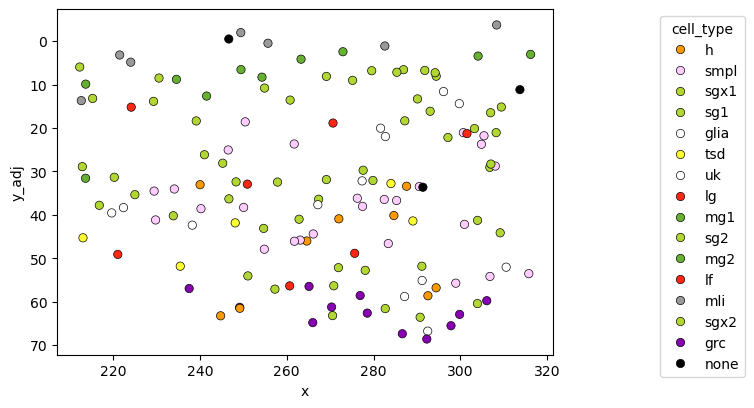

In [561]:
mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_type',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()

3 not yet identified out of 145 total


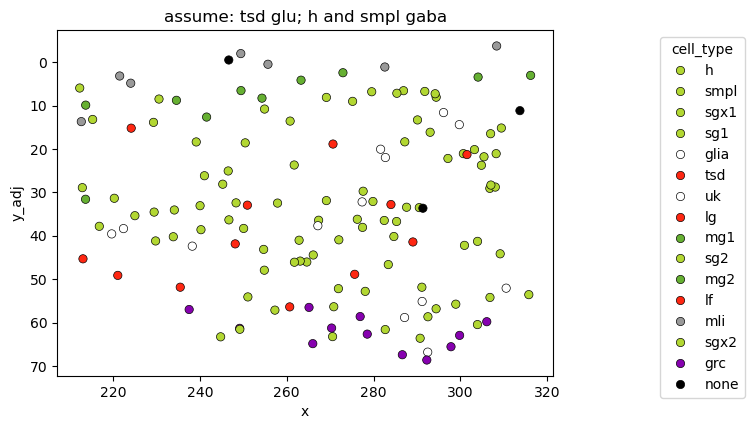

In [565]:
cell_cat_colors['h'] = '#B2D732' #green
cell_cat_colors['tsd'] = '#FE2712' #red
cell_cat_colors['smpl'] = '#B2D732'

mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_type',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()

ax.set_title('assume: tsd glu; h and smpl gaba');

3 not yet identified out of 145 total


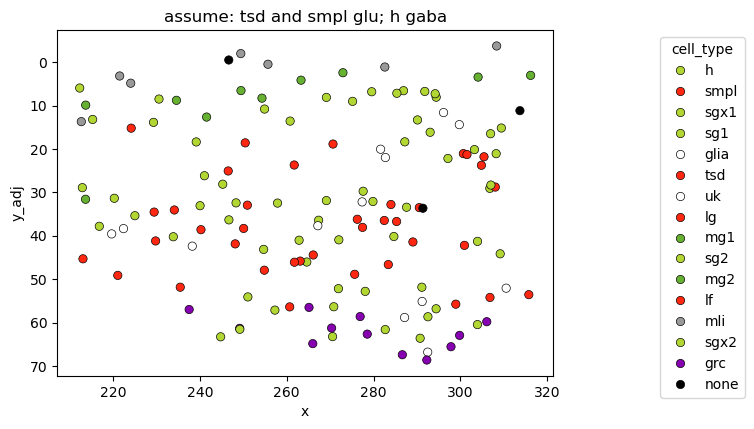

In [567]:
cell_cat_colors['h'] = '#B2D732' #green
cell_cat_colors['tsd'] = '#FE2712' #red
cell_cat_colors['smpl'] = '#FE2712'

mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_type',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_title('assume: tsd and smpl glu; h gaba');

3 not yet identified out of 145 total


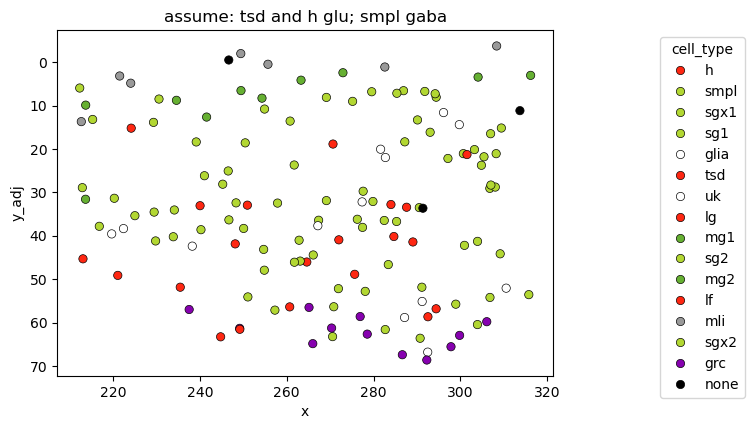

In [568]:
cell_cat_colors['h'] = '#FE2712' #red
cell_cat_colors['tsd'] = '#FE2712'
cell_cat_colors['smpl'] = '#B2D732' #green

mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_type',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_title('assume: tsd and h glu; smpl gaba');

3 not yet identified out of 145 total


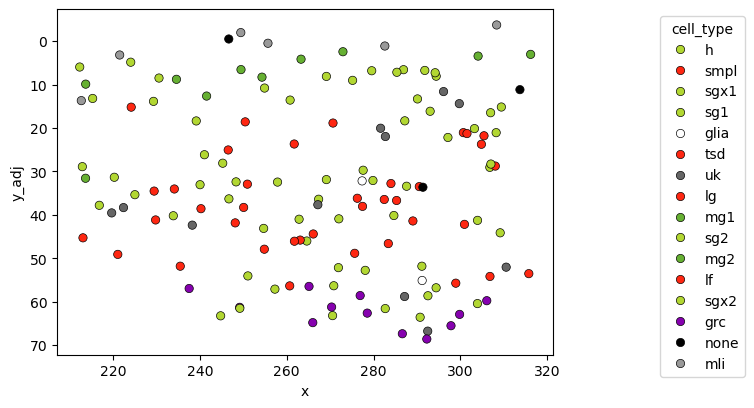

In [526]:
cell_cat_colors['h'] = '#B2D732'
cell_cat_colors['tsd'] = '#FE2712'
cell_cat_colors['smpl'] = '#FE2712'

mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_type',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()

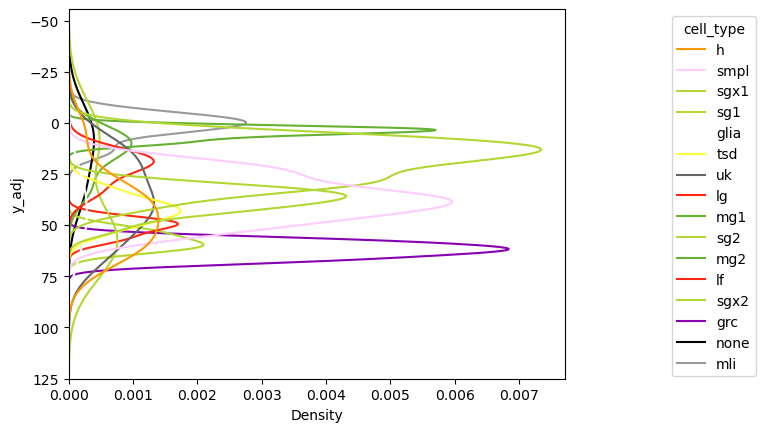

In [497]:

hfig,ax = plt.subplots(1)
sns.kdeplot(ax=ax,data=df_segments,y = 'y_adj',hue='cell_type',palette=cell_cat_colors,common_norm=True)
ax.invert_yaxis()
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# categorize cell types

In [502]:

# Function to categorize cell types
def categorize_cell_type(cell_type):
    if cell_type in glu_types:
        return 'glu'
    elif cell_type in gaba_types:
        return 'gaba'
    else:
        return 'other'  # Use 'other' for any types not categorized



,Unnamed: 0,x,y,z,segment,cell_id,cell_type,y_adj,cell_category,y_adj_bin
0,2,264.624,300.928,53.88,392163654,306291045,h,46.019922,glu,40
1,3,272.000,295.472,50.58,306306823,306306044,h,40.910453,glu,40
2,4,277.456,292.608,50.31,305177235,305176846,smpl,38.042250,glu,30
3,5,276.256,291.152,53.97,391049363,391049801,smpl,36.175787,glu,30
4,6,267.344,291.472,55.35,391034236,391034186,sgx1,36.401528,gaba,30


3 not yet identified out of 145 total


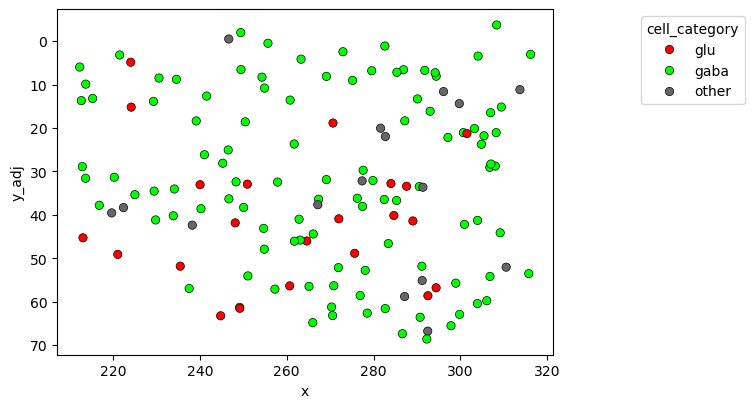

In [521]:

glu_types = ['lg', 'lf', 'tsd', 'h']
gaba_types = ['mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2', 'grc', 'mli','smpl']

# Create a new column with the categorized cell types
df_segments['cell_category'] = df_segments['cell_type'].apply(categorize_cell_type)

mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_category',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()

3 not yet identified out of 145 total


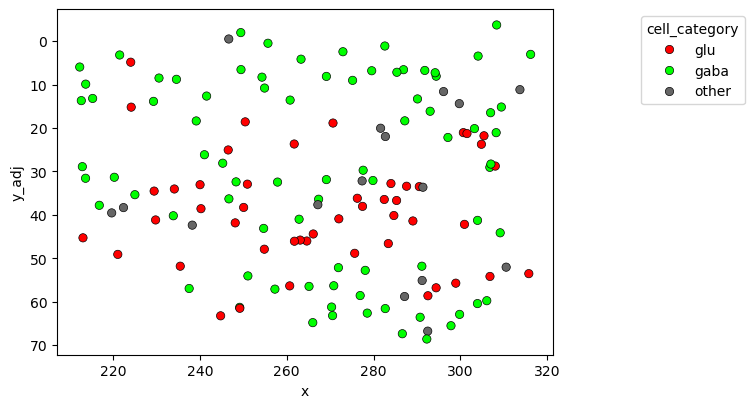

In [522]:

glu_types = ['lg', 'lf', 'tsd', 'h','smpl']
gaba_types = ['mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2', 'grc', 'mli']

# Create a new column with the categorized cell types
df_segments['cell_category'] = df_segments['cell_type'].apply(categorize_cell_type)

mask = df_segments['cell_type']=='none'
print(f'{sum(mask)} not yet identified out of {len(df_segments)} total')


hfig,ax = plt.subplots(1)
sns.scatterplot(ax=ax,data=df_segments,x = 'x',y = 'y_adj',hue='cell_category',palette=cell_cat_colors, edgecolor='black')
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));
ax.set_aspect('equal')
ax.invert_yaxis()

/var/folders/4n/x3rls3t16fn723p1tbd7w7fr0000gn/T/ipykernel_3332/4260081634.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df_segments.groupby(['y_adj_bin', 'cell_category']).size().unstack(fill_value=0)


Text(0, 0.5, 'gaba (green) and glu (red) count')

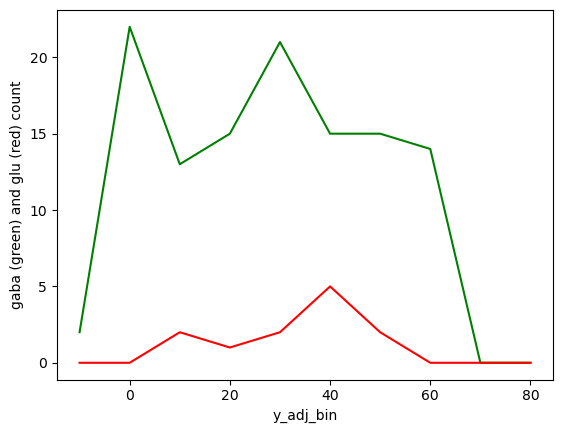

In [538]:

glu_types = ['lg', 'lf', 'tsd']
gaba_types = ['mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2', 'grc', 'mli','h', 'smpl']

# Create a new column with the categorized cell types
df_segments['cell_category'] = df_segments['cell_type'].apply(categorize_cell_type)

# Define bins for y_adj
bins = np.arange(-10, 100, 10)  
bin_labels = [f'Bin {i+1}' for i in range(len(bins)-1)]

# Cut y_adj into bins
df_segments['y_adj_bin'] = pd.cut(df_segments['y_adj'], bins=bins, labels=bins[0:-1])#,observed=False)

# Count the number of glu and gaba neurons in each bin
bin_counts = df_segments.groupby(['y_adj_bin', 'cell_category']).size().unstack(fill_value=0)

# Calculate the ratio of glu to gaba neurons
bin_counts['ratio'] = bin_counts['gaba'] / bin_counts['glu'].replace(0, np.nan)  # Replace 0 to avoid division by zero

hfig,ax = plt.subplots(1)
sns.lineplot(ax=ax,data=bin_counts.reset_index(),y='gaba',x='y_adj_bin',color='green')
sns.lineplot(ax=ax,data=bin_counts.reset_index(),y='glu',x='y_adj_bin',color='red')

ax.set_ylabel('gaba (green) and glu (red) count')

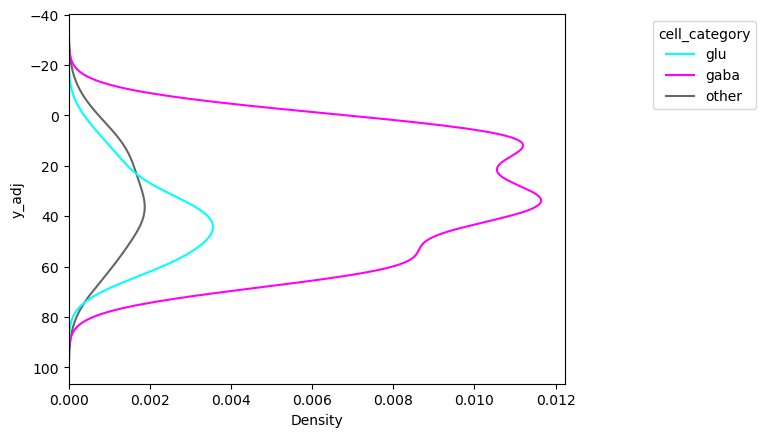

In [505]:

glu_types = ['lg', 'lf', 'tsd', 'h']
gaba_types = ['mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2', 'grc', 'mli','smpl']

# Create a new column with the categorized cell types
df_segments['cell_category'] = df_segments['cell_type'].apply(categorize_cell_type)

hfig,ax = plt.subplots(1)
sns.kdeplot(ax=ax,data=df_segments,y = 'y_adj',hue='cell_category',palette=cell_cat_colors,common_norm=True)
ax.invert_yaxis()
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

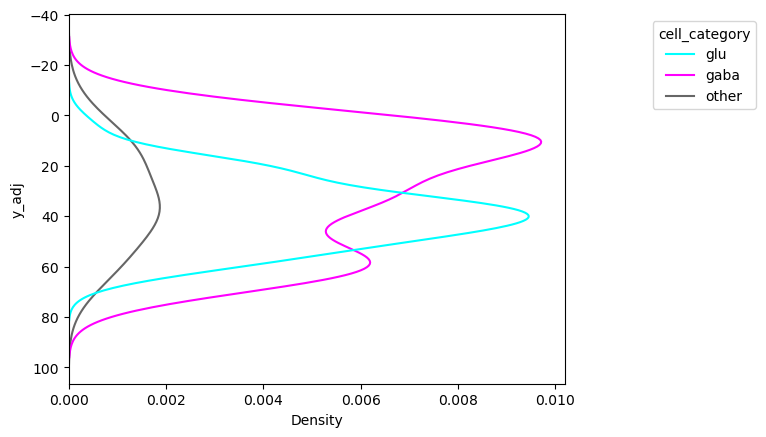

In [503]:

glu_types = ['lg', 'lf', 'tsd', 'h','smpl']
gaba_types = ['mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2', 'grc', 'mli']

# Create a new column with the categorized cell types
df_segments['cell_category'] = df_segments['cell_type'].apply(categorize_cell_type)

hfig,ax = plt.subplots(1)
sns.kdeplot(ax=ax,data=df_segments,y = 'y_adj',hue='cell_category',palette=cell_cat_colors,common_norm=True)
ax.invert_yaxis()
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

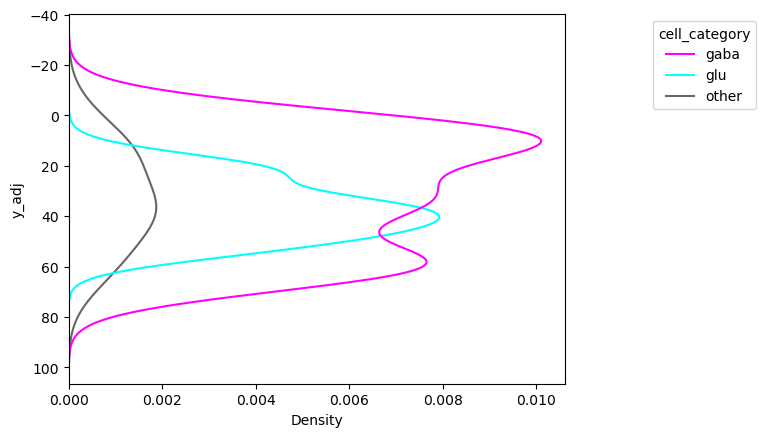

In [507]:

glu_types = ['lg', 'lf', 'tsd', 'smpl']
gaba_types = ['mg1', 'mg2', 'sg1', 'sg2', 'sgx1', 'sgx2', 'grc', 'mli','h']

# Create a new column with the categorized cell types
df_segments['cell_category'] = df_segments['cell_type'].apply(categorize_cell_type)

hfig,ax = plt.subplots(1)
sns.kdeplot(ax=ax,data=df_segments,y = 'y_adj',hue='cell_category',palette=cell_cat_colors,common_norm=True)
ax.invert_yaxis()
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));